In [145]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [2]:
# 사용자 / 기사 / 단어에 대한 더미 데이터 생성
users = ['user' + str(i) for i in range(1, 1001)]
articles = ['article' + str(i) for i in range(1, 1001)]
words = ['word' + str(i) for i in range(1, 1001)]

# 사용자 - 단어 학습 횟수 더미 데이터 생성
user_word_count = np.random.randint(0, 11, size = (1000, 1000))
user_word_df = pd.DataFrame(user_word_count, columns = words, index = users)

# 기사 - 단어 TF - IDF 더미 데이터 생성
article_word_tfidf = np.random.random(size = (1000, 1000))
article_word_df = pd.DataFrame(article_word_tfidf, columns = words, index = articles)

In [3]:
user_word_df

,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,...,word991,word992,word993,word994,word995,word996,word997,word998,word999,word1000
user1,2,0,6,6,2,1,4,9,9,10,...,8,2,8,9,10,5,7,6,2,7
user2,3,1,4,1,9,0,6,0,8,7,...,4,4,1,3,3,3,6,3,5,2
user3,10,6,0,6,8,8,10,10,7,10,...,4,1,4,8,6,0,2,0,9,0
user4,7,2,5,9,0,1,6,9,7,9,...,8,2,3,5,0,10,6,7,4,10
user5,3,6,2,9,7,8,4,6,6,5,...,10,7,2,5,2,2,2,4,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,10,10,5,6,3,8,3,3,10,2,...,5,3,9,2,5,3,2,7,6,3
user997,8,2,3,5,5,4,0,7,0,5,...,1,9,2,6,7,1,1,9,0,4
user998,7,5,9,6,9,5,4,1,1,9,...,6,2,4,0,9,4,1,10,9,10
user999,3,5,10,2,7,0,5,7,4,0,...,5,7,8,8,8,3,8,1,7,2


In [4]:
article_word_df

,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,...,word991,word992,word993,word994,word995,word996,word997,word998,word999,word1000
article1,0.580433,0.549031,0.063224,0.123421,0.934536,0.527689,0.888042,0.974761,0.308247,0.367123,...,0.318615,0.275553,0.649161,0.583827,0.801451,0.385378,0.286930,0.516924,0.516107,0.214774
article2,0.683099,0.636646,0.282245,0.208257,0.611683,0.281083,0.481357,0.953640,0.278934,0.890422,...,0.502110,0.880014,0.279811,0.302007,0.594622,0.765846,0.111025,0.615481,0.856074,0.711361
article3,0.691740,0.824698,0.255531,0.356012,0.347473,0.749450,0.699624,0.590178,0.913386,0.373837,...,0.634430,0.405371,0.801111,0.318034,0.167215,0.051618,0.012964,0.843329,0.446898,0.252904
article4,0.036688,0.819847,0.500688,0.483422,0.964827,0.777429,0.099337,0.000868,0.213992,0.315833,...,0.687034,0.136085,0.386479,0.898895,0.004698,0.089547,0.904688,0.775171,0.924403,0.205063
article5,0.347819,0.415990,0.085696,0.350341,0.500934,0.587390,0.544336,0.303222,0.099891,0.171099,...,0.822140,0.760745,0.588219,0.972867,0.821983,0.559122,0.199503,0.595613,0.639035,0.489095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
article996,0.689265,0.886978,0.696114,0.584490,0.151473,0.275905,0.204415,0.119168,0.842371,0.835384,...,0.164243,0.114139,0.044357,0.815805,0.936365,0.082860,0.810146,0.536222,0.986609,0.609872
article997,0.094054,0.362064,0.539149,0.416805,0.305034,0.421054,0.375785,0.119009,0.462587,0.419914,...,0.539350,0.992365,0.971686,0.595841,0.551910,0.984972,0.350136,0.811222,0.188530,0.355737
article998,0.003974,0.152945,0.261190,0.857112,0.693055,0.597921,0.795568,0.024999,0.821473,0.210192,...,0.943039,0.191395,0.725589,0.942617,0.243298,0.279309,0.391629,0.807646,0.127800,0.918314
article999,0.553732,0.116772,0.064424,0.062310,0.312309,0.817523,0.494523,0.331957,0.586524,0.284323,...,0.493633,0.660056,0.228318,0.483532,0.550806,0.874634,0.009590,0.467643,0.163997,0.518766


In [5]:
# 데이터 간 Scale을 맞추기 위하여 Min-Max 정규화
user_word_df_norm = (user_word_df - user_word_df.min()) / (user_word_df.max() - user_word_df.min())
user_word_df_norm

,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,...,word991,word992,word993,word994,word995,word996,word997,word998,word999,word1000
user1,0.2,0.0,0.6,0.6,0.2,0.1,0.4,0.9,0.9,1.0,...,0.8,0.2,0.8,0.9,1.0,0.5,0.7,0.6,0.2,0.7
user2,0.3,0.1,0.4,0.1,0.9,0.0,0.6,0.0,0.8,0.7,...,0.4,0.4,0.1,0.3,0.3,0.3,0.6,0.3,0.5,0.2
user3,1.0,0.6,0.0,0.6,0.8,0.8,1.0,1.0,0.7,1.0,...,0.4,0.1,0.4,0.8,0.6,0.0,0.2,0.0,0.9,0.0
user4,0.7,0.2,0.5,0.9,0.0,0.1,0.6,0.9,0.7,0.9,...,0.8,0.2,0.3,0.5,0.0,1.0,0.6,0.7,0.4,1.0
user5,0.3,0.6,0.2,0.9,0.7,0.8,0.4,0.6,0.6,0.5,...,1.0,0.7,0.2,0.5,0.2,0.2,0.2,0.4,0.6,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,1.0,1.0,0.5,0.6,0.3,0.8,0.3,0.3,1.0,0.2,...,0.5,0.3,0.9,0.2,0.5,0.3,0.2,0.7,0.6,0.3
user997,0.8,0.2,0.3,0.5,0.5,0.4,0.0,0.7,0.0,0.5,...,0.1,0.9,0.2,0.6,0.7,0.1,0.1,0.9,0.0,0.4
user998,0.7,0.5,0.9,0.6,0.9,0.5,0.4,0.1,0.1,0.9,...,0.6,0.2,0.4,0.0,0.9,0.4,0.1,1.0,0.9,1.0
user999,0.3,0.5,1.0,0.2,0.7,0.0,0.5,0.7,0.4,0.0,...,0.5,0.7,0.8,0.8,0.8,0.3,0.8,0.1,0.7,0.2


In [6]:
# 추천 방법 1 : Cosine 유사도 기반 Content-Based Filtering Algorithm
# 코사인 유사도 기반으로 사용자와 관련성이 높은 기사를 추천하는 방법

# 사용자 - 기사 간 코사인 유사도 계산
cosine_sim = cosine_similarity(user_word_df_norm, article_word_df)

# 코사인 유사도를 DataFrame으로 변환
cosine_sim_df = pd.DataFrame(cosine_sim, columns = articles, index = users)
cosine_sim_df

,article1,article2,article3,article4,article5,article6,article7,article8,article9,article10,...,article991,article992,article993,article994,article995,article996,article997,article998,article999,article1000
user1,0.737096,0.720874,0.721470,0.705927,0.721057,0.741046,0.734546,0.712330,0.729958,0.712457,...,0.715963,0.735586,0.728380,0.727059,0.725645,0.733055,0.739256,0.726514,0.744290,0.714826
user2,0.736432,0.745227,0.740753,0.749973,0.726561,0.727077,0.727501,0.731766,0.725339,0.728960,...,0.736207,0.718060,0.725853,0.730430,0.735599,0.745537,0.736024,0.743017,0.724918,0.724072
user3,0.730685,0.728833,0.724185,0.732102,0.714643,0.733757,0.714276,0.732680,0.717636,0.723800,...,0.727249,0.742423,0.719595,0.732081,0.723052,0.724180,0.728832,0.743198,0.740083,0.729078
user4,0.742433,0.726876,0.733274,0.725154,0.730020,0.737853,0.736000,0.726986,0.728031,0.723379,...,0.741932,0.729282,0.721036,0.726554,0.709248,0.729661,0.733767,0.726663,0.734824,0.728726
user5,0.744740,0.728191,0.741569,0.738903,0.723809,0.722428,0.744801,0.708653,0.723813,0.720927,...,0.730095,0.745545,0.725183,0.723024,0.728805,0.734447,0.749201,0.732624,0.743115,0.718289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.738819,0.743593,0.744707,0.729628,0.730644,0.744136,0.743317,0.726288,0.737661,0.747282,...,0.728393,0.738095,0.751767,0.737601,0.722724,0.739363,0.764361,0.736734,0.733938,0.728194
user997,0.758372,0.741999,0.719165,0.714236,0.714438,0.738428,0.735346,0.734841,0.721390,0.717574,...,0.744096,0.752233,0.741847,0.752434,0.719043,0.716149,0.723353,0.728058,0.724214,0.724166
user998,0.737780,0.736484,0.728214,0.745643,0.710978,0.725935,0.733753,0.715413,0.729366,0.738088,...,0.731548,0.729373,0.723695,0.728318,0.717205,0.741177,0.736718,0.726176,0.727262,0.718793
user999,0.734605,0.736171,0.746758,0.718674,0.740130,0.755260,0.742335,0.733430,0.734818,0.744408,...,0.733646,0.727354,0.733384,0.738965,0.741371,0.737629,0.754787,0.734678,0.735241,0.727050


In [7]:
# 각 사용자에 대한 추천 리스트 생성하여 추천 점수가 높은 기사 추천

# 실제로 구현할 때는 해당 기사가 이미 읽었던 기사인지, 아닌지 검증하는 과정 추가 필요

recommendations = {}
for user in users:
    user_data = cosine_sim_df.loc[user].sort_values(ascending=False)
    recommendations[user] = user_data.index.values.tolist()[:3]

for user in list(recommendations.keys()):
    print(f"{user}: {recommendations[user]}")

user1: ['article625', 'article67', 'article369']
user2: ['article949', 'article436', 'article796']
user3: ['article286', 'article518', 'article452']
user4: ['article564', 'article67', 'article158']
user5: ['article899', 'article254', 'article747']
user6: ['article375', 'article796', 'article379']
user7: ['article639', 'article617', 'article898']
user8: ['article778', 'article547', 'article514']
user9: ['article740', 'article393', 'article602']
user10: ['article448', 'article632', 'article669']
user11: ['article615', 'article423', 'article539']
user12: ['article34', 'article867', 'article107']
user13: ['article468', 'article244', 'article843']
user14: ['article514', 'article578', 'article802']
user15: ['article715', 'article489', 'article754']
user16: ['article595', 'article565', 'article534']
user17: ['article246', 'article379', 'article292']
user18: ['article853', 'article714', 'article43']
user19: ['article597', 'article401', 'article624']
user20: ['article432', 'article937', 'articl

In [8]:
# 단어 추천 방법 : 해당 사용자가 아직 학습하지 않은 단어들 중 해당 사용자와 유사한 사용자들이 많이 학습한 단어를 추천하는 알고리즘

# 사용자 간 유사도 계산
user_similarity = cosine_similarity(user_word_df_norm)

# 유사도를 DataFrame으로 변환
user_similarity_df = pd.DataFrame(user_similarity, index = users, columns = users)
user_similarity_df

,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,...,user991,user992,user993,user994,user995,user996,user997,user998,user999,user1000
user1,1.000000,0.703238,0.704823,0.724813,0.715509,0.723257,0.721229,0.697621,0.707428,0.720776,...,0.719127,0.722959,0.714724,0.718479,0.701449,0.715359,0.719515,0.700303,0.706498,0.704632
user2,0.703238,1.000000,0.716549,0.739404,0.717808,0.722102,0.727690,0.736230,0.707448,0.707815,...,0.691657,0.711392,0.720298,0.707430,0.699110,0.705299,0.727614,0.718566,0.706476,0.727183
user3,0.704823,0.716549,1.000000,0.727215,0.712039,0.725986,0.707001,0.702602,0.717899,0.710583,...,0.720127,0.725268,0.714085,0.711222,0.717661,0.697716,0.705354,0.710699,0.715010,0.713349
user4,0.724813,0.739404,0.727215,1.000000,0.723775,0.729574,0.724590,0.721982,0.716283,0.712681,...,0.720307,0.712839,0.722685,0.697018,0.714543,0.698183,0.716452,0.716345,0.716051,0.707049
user5,0.715509,0.717808,0.712039,0.723775,1.000000,0.714385,0.712925,0.713054,0.721089,0.724729,...,0.721721,0.721981,0.711511,0.728093,0.703674,0.725014,0.716408,0.701943,0.720031,0.732448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.715359,0.705299,0.697716,0.698183,0.725014,0.709903,0.714861,0.712275,0.726047,0.726641,...,0.714049,0.723408,0.735247,0.725717,0.706958,1.000000,0.711142,0.714979,0.717351,0.742549
user997,0.719515,0.727614,0.705354,0.716452,0.716408,0.723461,0.715380,0.708391,0.704265,0.719957,...,0.715440,0.723576,0.711682,0.697313,0.707642,0.711142,1.000000,0.711699,0.711538,0.711725
user998,0.700303,0.718566,0.710699,0.716345,0.701943,0.704796,0.711334,0.705487,0.710242,0.716365,...,0.708609,0.713271,0.707982,0.721106,0.704767,0.714979,0.711699,1.000000,0.711936,0.713728
user999,0.706498,0.706476,0.715010,0.716051,0.720031,0.726012,0.715148,0.710196,0.712535,0.727163,...,0.714338,0.717907,0.717983,0.715469,0.724553,0.717351,0.711538,0.711936,1.000000,0.739841


In [9]:
# 사용자가 아직 학습하지 않은 단어 찾기
unlearned_words = user_word_df_norm[user_word_df_norm == 0]

# 추천 단어 리스트 생성
word_recommendations = {}
for user in users:
    # 사용자와 유사한 사용자들 찾기
    similar_users = user_similarity_df[user].sort_values(ascending=False).index[1:]

    # 유사한 사용자들이 많이 학습한 단어 찾기
    similar_users_words = user_word_df_norm.loc[similar_users].mean().sort_values(ascending=False)

    # 사용자가 아직 학습하지 않은 단어 중에서 유사한 사용자들이 많이 학습한 단어 선택
    user_unlearned_words = unlearned_words.loc[user].dropna()
    recommended_words = similar_users_words.loc[user_unlearned_words.index]

    # 상위 3개 단어 추천
    word_recommendations[user] = recommended_words.sort_values(ascending=False).index[:1].tolist()

In [10]:
print(word_recommendations)

{'user1': ['word561'], 'user2': ['word475'], 'user3': ['word775'], 'user4': ['word360'], 'user5': ['word775'], 'user6': ['word140'], 'user7': ['word71'], 'user8': ['word798'], 'user9': ['word724'], 'user10': ['word775'], 'user11': ['word475'], 'user12': ['word360'], 'user13': ['word140'], 'user14': ['word856'], 'user15': ['word561'], 'user16': ['word814'], 'user17': ['word303'], 'user18': ['word645'], 'user19': ['word475'], 'user20': ['word756'], 'user21': ['word814'], 'user22': ['word207'], 'user23': ['word520'], 'user24': ['word856'], 'user25': ['word374'], 'user26': ['word209'], 'user27': ['word520'], 'user28': ['word520'], 'user29': ['word475'], 'user30': ['word209'], 'user31': ['word303'], 'user32': ['word312'], 'user33': ['word775'], 'user34': ['word360'], 'user35': ['word374'], 'user36': ['word756'], 'user37': ['word548'], 'user38': ['word786'], 'user39': ['word312'], 'user40': ['word303'], 'user41': ['word360'], 'user42': ['word522'], 'user43': ['word360'], 'user44': ['word814'

In [155]:
# 단어 추천 방법 2 : Matrix Factorization
# 행렬을 두 개의 저차원 행렬로 분해하여 각각 사용자와 단어의 잠재적 특성을 나타냄
# 잠재적 특성을 기반으로 사용자와 단어 사이의 관계를 예측

class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, l2=0.01):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.l2 = l2

    def forward(self, user_indices, item_indices):
        user_latent = self.user_embedding(user_indices)
        item_latent = self.item_embedding(item_indices)
        user_bias = self.user_bias(user_indices).squeeze()
        item_bias = self.item_bias(item_indices).squeeze()
        
        prediction = torch.sum(user_latent * item_latent, dim=1)
        prediction += user_bias + item_bias
        return prediction

    def loss(self, prediction, target):
        loss = F.mse_loss(prediction, target)
        l2_reg = (self.user_embedding.weight.norm() + self.item_embedding.weight.norm() + self.user_bias.weight.norm() + self.item_bias.weight.norm()) * self.l2
        return loss + l2_reg

# 데이터셋 클래스 정의
class UserWordDataset(Dataset):
    def __init__(self, data):
        self.users = data.index.repeat(len(data.columns))
        self.items = np.tile(data.columns, len(data.index))
        self.ratings = data.values.flatten().astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [149]:
user_word_df.columns = range(user_word_df.shape[1])
user_word_df.index = range(user_word_df.shape[0])

print(user_word_df)
print(user_word_df.info())

     0    1    2    3    4    5    6    7    8    9    ...  990  991  992  \
0      2    0    6    6    2    1    4    9    9   10  ...    8    2    8   
1      3    1    4    1    9    0    6    0    8    7  ...    4    4    1   
2     10    6    0    6    8    8   10   10    7   10  ...    4    1    4   
3      7    2    5    9    0    1    6    9    7    9  ...    8    2    3   
4      3    6    2    9    7    8    4    6    6    5  ...   10    7    2   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
995   10   10    5    6    3    8    3    3   10    2  ...    5    3    9   
996    8    2    3    5    5    4    0    7    0    5  ...    1    9    2   
997    7    5    9    6    9    5    4    1    1    9  ...    6    2    4   
998    3    5   10    2    7    0    5    7    4    0  ...    5    7    8   
999    2   10    9    1    9    8    9    1   10    4  ...    0    3    7   

     993  994  995  996  997  998  999  
0      9   10    5    7    6    2 

In [161]:
# 데이터 로딩
dataset = UserWordDataset(user_word_df)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

# 모델 초기화
num_users, num_items = len(user_word_df.index), len(user_word_df.columns)
model = MatrixFactorization(num_users, num_items, 100)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 진행
for epoch in range(5):  # 적절한 epoch 수로 설정
    for data_loader in [train_loader, valid_loader]:
        for user_indices, item_indices, ratings in data_loader:
            # 예측
            prediction = model(user_indices, item_indices)
            loss = model.loss(prediction, ratings)
        
            # 역전파 및 최적화
            if data_loader == train_loader:  # Only update model weights based on training data
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
        print(f"Epoch {epoch+1} Loss {loss.item()}")

# 사용자별 단어 추천
for user_index in range(num_users):
    # 학습되지 않은 단어 인덱스를 찾아서 설정
    untrained_item_indices = user_word_df.loc[user_index+1][user_word_df.loc[user_index+1] == 0].index.tolist()
    
    # 학습되지 않은 단어들만 예측 대상으로 설정
    untrained_item_indices_tensor = torch.tensor(untrained_item_indices)
    predictions = model(torch.tensor([user_index]*len(untrained_item_indices)), untrained_item_indices_tensor)
    
    # 학습되지 않은 단어들 중에서 가장 높은 예측 점수를 가진 단어를 추천
    recommended_item_index = untrained_item_indices[torch.argmax(predictions).item()]

Epoch 1 Loss 17.298837661743164
Epoch 1 Loss 16.65275764465332
Epoch 2 Loss 16.15174102783203
Epoch 2 Loss 15.752593040466309
Epoch 3 Loss 18.097209930419922
Epoch 3 Loss 16.296459197998047
Epoch 4 Loss 13.851991653442383
Epoch 4 Loss 15.075845718383789
Epoch 5 Loss 14.805641174316406
Epoch 5 Loss 15.766626358032227


KeyError: 1000

In [162]:
# 사용자별 단어 추천
for user_index in range(num_users):
    # 학습되지 않은 단어 인덱스를 찾아서 설정
    untrained_item_indices = user_word_df.loc[user_index][user_word_df.loc[user_index] == 0].index.tolist()
    
    # 학습되지 않은 단어들만 예측 대상으로 설정
    untrained_item_indices_tensor = torch.tensor(untrained_item_indices)
    predictions = model(torch.tensor([user_index]*len(untrained_item_indices)), untrained_item_indices_tensor)
    
    # 학습되지 않은 단어들 중에서 가장 높은 예측 점수를 가진 단어를 추천
    recommended_item_index = untrained_item_indices[torch.argmax(predictions).item()]

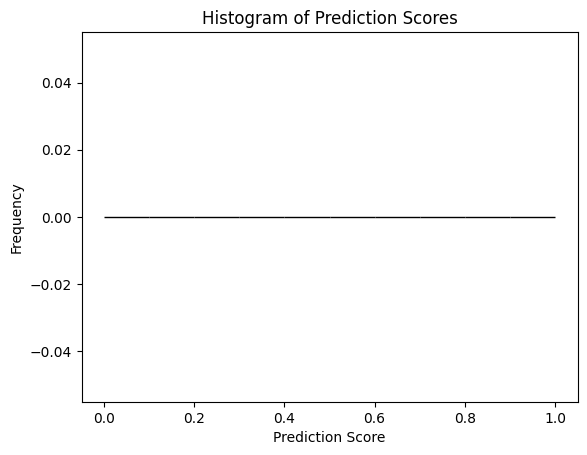

In [13]:
# 예측 점수를 리스트로 모음
estimates = [est for uid, iid, true_r, est, _ in predictions]

# 히스토그램 그리기
plt.hist(estimates, bins = 10, edgecolor = 'black')
plt.title('Histogram of Prediction Scores')
plt.xlabel('Prediction Score')
plt.ylabel('Frequency')
plt.show()